In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [8]:
#the api key from azure
key = os.environ.get('', '92aa46428c714ddab247b132a0d42d57')

In [9]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [10]:
results = search_images_bing(key, 'dove')
ims = results.attrgot('contentUrl')
len(ims)

150

In [11]:
ims

(#150) ['https://upload.wikimedia.org/wikipedia/commons/thumb/0/0b/Eurasian_collared-dove_(Streptopelia_decaocto).jpg/1200px-Eurasian_collared-dove_(Streptopelia_decaocto).jpg','https://www.goodfreephotos.com/albums/vector-images/dove-vector-clipart.png','https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Ring-necked_dove_%28Streptopelia_capicola_damarensis%29.jpg/1200px-Ring-necked_dove_%28Streptopelia_capicola_damarensis%29.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Feral_Barbary_Dove.jpg/1200px-Feral_Barbary_Dove.jpg','https://i.ytimg.com/vi/OFHcXh5FxiM/hqdefault.jpg','http://images.clipartpanda.com/christian-dove-clipart-RTd6qBjT9.png','https://upload.wikimedia.org/wikipedia/en/5/5f/WhiteDove912.jpg','https://upload.wikimedia.org/wikipedia/commons/0/04/Columbina_passerina_-near_Salton_Sea%2C_California%2C_USA-8.jpg','https://sites.psu.edu/birdsofpa/files/2016/12/Mourning_dove-1ryyytn.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Paloma_

In [13]:
dest = 'images/dove.jpg'
download_url(ims[0], dest)

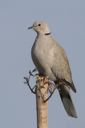

In [14]:
im = Image.open(dest)
im.to_thumb(128,128)

In [15]:
bird_types = 'dove', 'segull', 'crow'
path = Path('birds')

In [16]:
if not path.exists():
    path.mkdir()
    for o in bird_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [17]:
fns = get_image_files(path)
fns

(#429) [Path('birds/dove/00000004.jpg'),Path('birds/dove/00000001.png'),Path('birds/dove/00000002.jpg'),Path('birds/dove/00000000.jpg'),Path('birds/dove/00000005.png'),Path('birds/dove/00000003.jpg'),Path('birds/dove/00000007.jpg'),Path('birds/dove/00000006.jpg'),Path('birds/dove/00000009.JPG'),Path('birds/dove/00000008.jpg')...]

In [18]:
# checkinging if any images are corrupt
failed = verify_images(fns)
failed

(#3) [Path('birds/segull/00000069.jpg'),Path('birds/segull/00000080.jpg'),Path('birds/crow/00000123.jpg')]

In [19]:
#remove corrupt images

failed.map(Path.unlink)

(#3) [None,None,None]

In [20]:
birds = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter= RandomSplitter(valid_pct=0.2, seed= 42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [21]:
#tells fastai the source of our data
birds = birds.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = birds.dataloaders(path)

In [22]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.646247,0.749957,0.235294,00:09


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.412796,0.312011,0.117647,00:09
1,0.306515,0.165109,0.047059,00:10
2,0.233293,0.162522,0.035294,00:09
3,0.188702,0.169464,0.035294,00:09


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


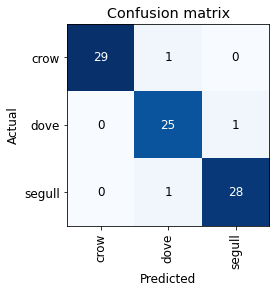

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

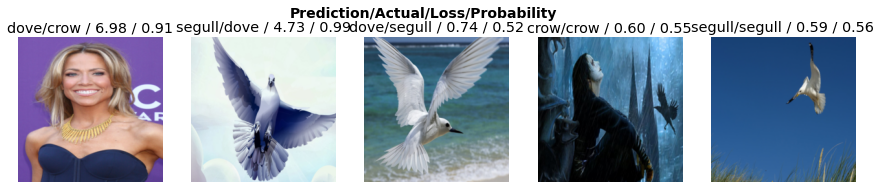

In [24]:
interp.plot_top_losses(5, nrows=1)

Turining the model into an Online Application


In [25]:
learn.export()

In [26]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [27]:
learn_inf = load_learner(path/'export.pkl')

In [28]:
learn_inf.predict('images/dove.jpg')

('dove', tensor(1), tensor([0.0028, 0.9936, 0.0035]))

In [29]:
learn_inf.dls.vocab

['crow', 'dove', 'segull']

In [30]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [31]:
btn_upload = SimpleNamespace(data = ['images/dove.jpg'])

In [32]:
img = PILImage.create(btn_upload.data[-1])

In [33]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [34]:
pred,pred_idx,probs = learn_inf.predict(img)

In [35]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: dove; Probability: 0.9936')

In [36]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [37]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [38]:
btn_upload = widgets.FileUpload()

In [39]:
VBox([widgets.Label('Select your bird!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

Creating a real app


In [40]:
!pip install voila

     |████████████████████████████████| 1.9 MB 23.2 MB/s eta 0:00:01
     |████████████████████████████████| 552 kB 70.3 MB/s eta 0:00:01
     |████████████████████████████████| 184 kB 64.1 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 4.0 MB/s  eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

nbdev 1.1.5 requires nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.


In [41]:
!jupyter serverextension enable --sys-prefix voila

Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.6 OK
